# CNN + GlobalAvgPool 
Based on CNN 107 which got 75% acc on H1 coding len 2000-4000.  
Model: Embed mask, Conv1D, GlobalAvgPool.   

H1 coding len 4000-5000.  
Cross validation 5 folds 5 epochs, accuracy mean , F1 mean 


In [56]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-29 15:03:15.329661
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [57]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import Flatten
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=16
DCELLS=8
EPOCHS=5
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=4000
MAXLEN=5000   

In [58]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [59]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [60]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=1
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 1 = H1.hESC


## Data Load

In [61]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [62]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2022-12-29 15:03:17.926263
Load RCI values...
Num RCI: 13000
Example RCI: [('ENSG00000000003', 1.85734), ('ENSG00000000005', 5.88264), ('ENSG00000000419', 2.58954)]
Load genes...
2022-12-29 15:03:17.956605
Load sequence...
2022-12-29 15:03:27.047176
Num IDs: 4396
Example IDs: [('ENSG00000130764', 'ENST00000378251.3'), ('ENSG00000171680', 'ENST00000377740.5'), ('ENSG00000116688', 'ENST00000675053.1'), ('ENSG00000188984', 'ENST00000359318.8')]
Count 1805 ones out of 4396 labels.
Example labels: [1, 0, 0, 1]
Num counts: 4396
Example sequence: [155, 106, 168, 159, 122, 231, 156, 110, 181, 211, 75, 43, 169, 164, 144, 62, 246, 216, 96, 127, 251, 236, 175, 187, 234, 166, 150, 88, 95, 123, 233, 163, 139, 43, 172, 175, 187, 233, 164, 141, 51, 203, 42, 168, 159, 123, 234, 166, 152, 95, 123, 235, 171, 171, 170, 166, 149, 84, 78, 53, 211, 75, 41, 162, 133, 19, 74, 37, 147, 75, 44, 175, 185, 226, 135, 27, 108, 174, 181, 211, 75, 42, 166, 149, 81, 68, 15, 58, 230, 149, 83, 74, 38, 151, 91, 107, 170,

## Model

In [63]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    #pool_layer = MaxPooling1D(pool_size=3)
    pool_layer = GlobalAveragePooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(pool_layer)
    #rnn.add(flat_layer)
    #rnn.add(den1_layer)
    #rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [64]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-29 15:03:27.081624
COMPILE
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 4997, 4)           1028      
                                                                 
 conv1d_30 (Conv1D)          (None, 4990, 64)          2112      
                                                                 
 global_average_pooling1d_30  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_61 (Dense)            (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [65]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2022-12-29 15:03:27.406122
2022-12-29 15:03:27.406268
splitting
Fold 1
Training example
[181 210  71 ...   0   0   0]
Train sizes (3492, 4997) (3492, 1)
Valid sizes (904, 4997) (904, 1)
Train set ones/size 1394 / 3492
Valid set ones/size 411 / 904
BUILD MODEL
COMPILE
FIT
2022-12-29 15:03:28.735356
Epoch 1/5
110/110 [==============================] - 2s 10ms/step - loss: 0.6265 - accuracy: 0.6300 - val_loss: 0.5648 - val_accuracy: 0.7080
Epoch 2/5
110/110 [==============================] - 1s 9ms/step - loss: 0.5343 - accuracy: 0.7211 - val_loss: 0.5384 - val_accuracy: 0.7555
Epoch 3/5
110/110 [==============================] - 1s 8ms/step - loss: 0.5251 - accuracy: 0.7325 - val_loss: 0.5261 - val_accuracy: 0.7566
Epoch 4/5
110/110 [==============================] - 1s 8ms/step - loss: 0.5193 - accuracy: 0.7297 - val_loss: 0.5253 - val_accuracy: 0.7611
Epoch 5/5
110/110 [==============================] - 1s 9ms/step - loss: 0.5134 - accuracy: 0.7374 - val_loss: 0.5163 - val_accuracy: 0.

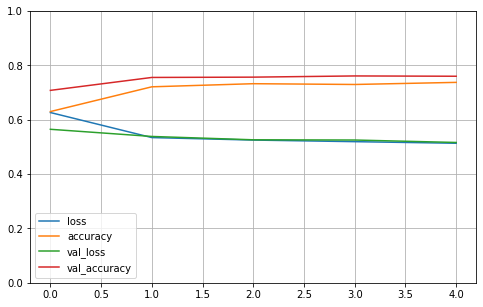

Compute valiation accuracy
2022-12-29 15:03:34.646819
Range of scores: 0.0072964923 to 0.9281597
Predicted zeros and ones 506 398
Accuracy: 76.00% Precision: 74.37% Recall: 72.02% F1: 73.18%
2022-12-29 15:03:34.912017
Fold 2
Training example
[ 35 138  38 ...   0   0   0]
Train sizes (3556, 4997) (3556, 1)
Valid sizes (840, 4997) (840, 1)
Train set ones/size 1484 / 3556
Valid set ones/size 321 / 840
BUILD MODEL
COMPILE
FIT
2022-12-29 15:03:36.232691
Epoch 1/5
112/112 [==============================] - 2s 10ms/step - loss: 0.6348 - accuracy: 0.6282 - val_loss: 0.5316 - val_accuracy: 0.7155
Epoch 2/5
112/112 [==============================] - 1s 8ms/step - loss: 0.5382 - accuracy: 0.7326 - val_loss: 0.5244 - val_accuracy: 0.7131
Epoch 3/5
112/112 [==============================] - 1s 9ms/step - loss: 0.5314 - accuracy: 0.7399 - val_loss: 0.5218 - val_accuracy: 0.7167
Epoch 4/5
112/112 [==============================] - 1s 8ms/step - loss: 0.5252 - accuracy: 0.7379 - val_loss: 0.5240 - val

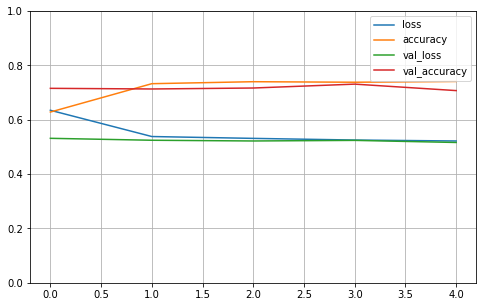

Compute valiation accuracy
2022-12-29 15:03:42.153812
Range of scores: 0.008829447 to 0.9119773
Predicted zeros and ones 483 357
Accuracy: 70.71% Precision: 60.50% Recall: 67.29% F1: 63.72%
2022-12-29 15:03:42.342096
Fold 3
Training example
[ 35 138  38 ...   0   0   0]
Train sizes (3462, 4997) (3462, 1)
Valid sizes (934, 4997) (934, 1)
Train set ones/size 1439 / 3462
Valid set ones/size 366 / 934
BUILD MODEL
COMPILE
FIT
2022-12-29 15:03:43.679688
Epoch 1/5
109/109 [==============================] - 2s 11ms/step - loss: 0.6290 - accuracy: 0.6308 - val_loss: 0.5222 - val_accuracy: 0.7441
Epoch 2/5
109/109 [==============================] - 1s 8ms/step - loss: 0.5429 - accuracy: 0.7244 - val_loss: 0.5032 - val_accuracy: 0.7537
Epoch 3/5
109/109 [==============================] - 1s 8ms/step - loss: 0.5344 - accuracy: 0.7244 - val_loss: 0.5023 - val_accuracy: 0.7527
Epoch 4/5
109/109 [==============================] - 1s 8ms/step - loss: 0.5283 - accuracy: 0.7270 - val_loss: 0.4977 - val_

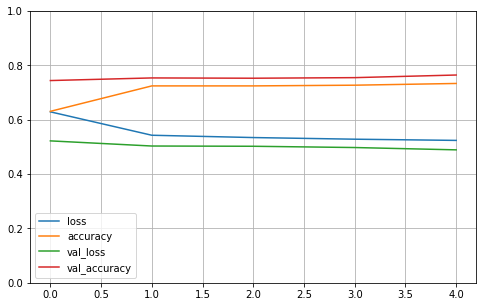

Compute valiation accuracy
2022-12-29 15:03:49.965836
Range of scores: 0.014881373 to 0.9147696
Predicted zeros and ones 526 408
Accuracy: 76.45% Precision: 67.89% Recall: 75.68% F1: 71.58%
2022-12-29 15:03:50.217038
Fold 4
Training example
[ 35 138  38 ...   0   0   0]
Train sizes (3589, 4997) (3589, 1)
Valid sizes (807, 4997) (807, 1)
Train set ones/size 1485 / 3589
Valid set ones/size 320 / 807
BUILD MODEL
COMPILE
FIT
2022-12-29 15:03:51.527117
Epoch 1/5
113/113 [==============================] - 2s 10ms/step - loss: 0.6262 - accuracy: 0.6325 - val_loss: 0.5439 - val_accuracy: 0.7088
Epoch 2/5
113/113 [==============================] - 1s 8ms/step - loss: 0.5309 - accuracy: 0.7347 - val_loss: 0.5423 - val_accuracy: 0.7187
Epoch 3/5
113/113 [==============================] - 1s 8ms/step - loss: 0.5216 - accuracy: 0.7392 - val_loss: 0.5566 - val_accuracy: 0.7162
Epoch 4/5
113/113 [==============================] - 1s 8ms/step - loss: 0.5178 - accuracy: 0.7425 - val_loss: 0.5370 - val_

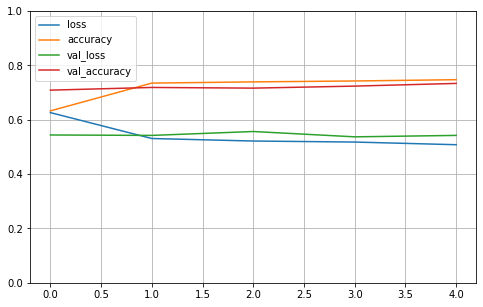

Compute valiation accuracy
2022-12-29 15:03:57.415023
Range of scores: 0.008283462 to 0.93931246
Predicted zeros and ones 420 387
Accuracy: 73.36% Precision: 63.57% Recall: 76.88% F1: 69.59%
2022-12-29 15:03:57.661634
Fold 5
Training example
[ 35 138  38 ...   0   0   0]
Train sizes (3485, 4997) (3485, 1)
Valid sizes (911, 4997) (911, 1)
Train set ones/size 1418 / 3485
Valid set ones/size 387 / 911
BUILD MODEL
COMPILE
FIT
2022-12-29 15:03:58.958770
Epoch 1/5
109/109 [==============================] - 2s 10ms/step - loss: 0.6191 - accuracy: 0.6370 - val_loss: 0.5623 - val_accuracy: 0.7146
Epoch 2/5
109/109 [==============================] - 1s 8ms/step - loss: 0.5260 - accuracy: 0.7308 - val_loss: 0.5606 - val_accuracy: 0.7157
Epoch 3/5
109/109 [==============================] - 1s 8ms/step - loss: 0.5163 - accuracy: 0.7403 - val_loss: 0.5546 - val_accuracy: 0.7135
Epoch 4/5
109/109 [==============================] - 1s 8ms/step - loss: 0.5091 - accuracy: 0.7501 - val_loss: 0.5511 - val

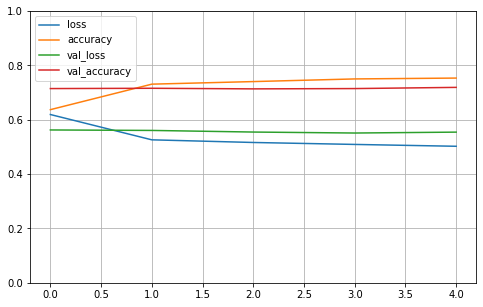

Compute valiation accuracy
2022-12-29 15:04:04.853634
Range of scores: 0.012285362 to 0.94483435
Predicted zeros and ones 478 433
Accuracy: 71.90% Precision: 65.13% Recall: 72.87% F1: 68.78%
2022-12-29 15:04:05.046196

Cross validation 5 folds 5 epochs
 accuracy mean 73.68% +/- 2.24
 precision mean 66.29% +/- 4.69
 recall mean 72.95% +/- 3.34
 F1 mean 69.37% +/- 3.22
2022-12-29 15:04:05.048169


In [66]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())